In [1]:
import numpy as np
import time as t
import math as m
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io
from  matplotlib.animation import FuncAnimation
from scipy.signal import convolve2d
from scipy import ndimage
import matplotlib.patches as patches

from scipy.optimize import least_squares
from scipy.signal import savgol_filter

In [2]:
def load_tiff_movie(pathname, filename):
    fullpath = pathname + filename
    # read the image stack
    imgs = np.array(io.imread(fullpath))
    return imgs, imgs.shape[0]

In [3]:
pathname = 'C:/Users/icedn/Jupyter/SelvinLab/MatLab to Python/'
filename = 'TSB_488.tif'
rawframes, numframe = load_tiff_movie(pathname, filename)

TiffTag 5033: coercing invalid ASCII to bytes


TiffTag 5033: coercing invalid ASCII to bytes
MovieWriter ffmpeg unavailable; using Pillow instead.


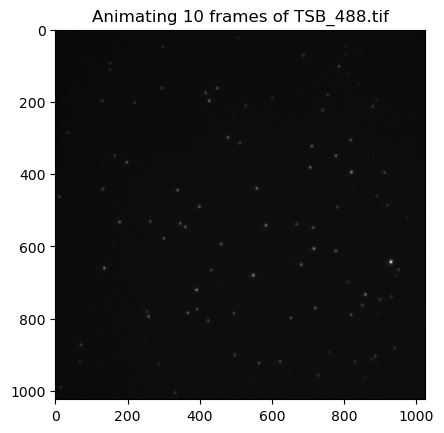

In [15]:
def create_tiff_animation(pathname, filename):
    data, n_frames = load_tiff_movie(pathname, filename)

    fig, ax = plt.subplots()
    plot = ax.imshow(data[0], cmap="gray", animated=True)
    plt.title(f"Animating {n_frames} frames of {filename}")
    def update(i):
        if i==0: 
            return
        plot = ax.imshow(data[i], cmap="gray", animated=True)
        return [plot]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = 50, repeat=False, cache_frame_data=True)
    anim.save(f"{filename[:-4]}_animated.gif")
    plt.show()
create_tiff_animation(pathname, filename)

In [16]:
## FUNCTION TRANSLATED BY CHATGPT
## Gaussian_image_filtering.m translated, should work the same after one tweak (noted below)
def Gaussian_image_filtering(I, R, to_print=False):
    # Compute FFT of the grey image
    A = np.fft.fft2(I.astype(float))
    A1 = np.fft.fftshift(A) # frequency scaling
    
    # Gaussian Filter Response Calculation
    M, N = I.shape
    X, Y = np.meshgrid(np.arange(N), np.arange(M))
    Cx, Cy = 0.5*N, 0.5*M
    ## Lo = np.exp(-((X-Cx)**2 + (Y-Cy)**2) / (2*R**2)) ## Original ChatGPT Translation
    ## Fixed below? I was comparing to the MATLAB and I think the 2 is squared as well in (2*R**2)
    Lo = np.exp(-((X-Cx)**2 + (Y-Cy)**2) / ((2*R)**2)) 
    Hi = 1 - Lo # High pass filter=1-low pass filter
    
    # Filtered image=ifft(filter response*fft(original image))
    J = A1 * Lo
    J1 = np.fft.ifftshift(J)
    ## B1 = np.fft.ifft2(J1).real ## Original CHATGPT
    B1 = np.abs(np.fft.ifft2(J1))
    K = A1 * Hi
    K1 = np.fft.ifftshift(K)
    ## B2 = np.fft.ifft2(K1).real ## Original CHATGPT
    B2 = np.abs(np.fft.ifft2(K1))
    
    # Display input image and filtered output
    if to_print:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(I, cmap='gray')
        axs[0].set_title('Input image')
        axs[0].axis('off')
        axs[1].imshow(np.abs(B1), cmap='gray')
        axs[1].set_title('Filtered image')
        axs[1].axis('off')
        plt.show()
    
    return B1, B2
B1, B2 = Gaussian_image_filtering(rawframes[0], 15)

In [17]:
## Slightly different version, some changes in between the comment lines
def FastPeakFind(d, thres=None, filt=None, edg=3, res=1, fid=None):
    """
    Analyze noisy 2D images and find peaks using local maxima (1 pixel
    resolution) or weighted centroids (sub-pixel resolution).
    The code is designed to be as fast as possible, so I kept it pretty basic.
    The code assumes that the peaks are relatively sparse, test whether there
    is too much pile up and set threshold or user defined filter accordingly.
    """
    # defaults
    original = d.copy()
    varargout = ()
    
    if d.ndim > 2: # added in case one uses imread (JPG\PNG\...).
        d = np.uint16(np.mean(d, axis=-1))
        
    if np.issubdtype(d.dtype, np.floating):
        if np.max(d) <= 1:
            d = np.uint16(d * (2**16 / np.max(d)))
        else:
            d = np.uint16(d)
    
    if thres is None:
        thres = np.min([np.max(d, axis=0).min(), np.max(d, axis=1).min()])
    
    if filt is None:
        filt = np.zeros((7,7))
        filt[3,3] = 1
        filt = ndimage.gaussian_filter(filt, 1)
    
    # analyze image
    if np.sum(d) != 0:
        d = ndimage.median_filter(d, size=3)      
        d = d * (d > thres)
        if np.sum(d) != 0:
            d = convolve2d(d, filt, mode='same')
            d = d * (d > 0.9*thres)
            if res == 1:
                sd = d.shape
                y, x = np.where(d[edg:sd[0]-edg, edg:sd[1]-edg] != 0)
                cent = []
                cent_map = np.zeros(sd)
                
                x += edg
                y += edg
                for j in range(len(y)):
                    row, col = y[j], x[j]
                    is_max = True
                    for i in [-1, 0, 1]:
                        for k in [-1, 0, 1]:
                            if i == 0 and k == 0:
                                continue
                            if d[row, col] <= d[row+i, col+k]:
                                is_max = False
                                break
                        if not is_max:
                            break
                    if is_max:
                        cent.append([col, row])
                        cent_map[row, col] += 1
            elif res == 3:
                sd = d.shape
                y, x = np.where(d[edg:sd[0]-edg, edg:sd[1]-edg] != 0)
                x += edg
                y += edg
                cent_map = np.zeros(sd)
                for j in range(len(x)):
                    if d[y[j], x[j]] == np.max(d[y[j]-1:y[j]+2, x[j]-1:x[j]+2]):
                        cent_map[y[j], x[j]] += 1
                mask = cent_map == np.max(cent_map)
                cent = np.column_stack(np.nonzero(mask))
            elif res == 2:
                peaks, num = ndimage.label(d > thres)
                y, x = ndimage.center_of_mass(d, peaks, range(1, num+1))
            else:
                raise ValueError("Invalid res value. Must be 1, 2, or 3.")
        else:
            print("Post-Threshold all zeros")
            cent = []
            cent_map = np.zeros(d.shape)
            varargout = (cent_map,)
            return cent, *varargout
    else:
        print("Raw Image all zeros")
        cent = []
        cent_map = np.zeros(d.shape)
        varargout = (cent_map,)
        return cent, *varargout
       
    # remove edge peaks ## Shouldn't be necessary
#     mask = (x > edg) & (x < (d.shape[1]-edg)) & (y > edg) & (y < (d.shape[0]-edg))
#     x = x[mask]
#     y = y[mask]
    
    # output results
#     cent = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    
    if fid is not None:
        np.savetxt(fid, cent, fmt='%d', delimiter=',')
    return np.array(cent), *varargout

In [18]:
def PSFfit(IMAGE, pxl_size):
    ny, nx = IMAGE.shape
    grid = [nx, ny, np.arange(1, nx+1), np.arange(1, ny+1)]
    popt, _, _, _ = gauss2dfit(np.abs(IMAGE), grid, 0)
    if popt.size != 0:
        xp = np.reshape(np.tile((grid[2:nx+2]-popt[4])/popt[2], (ny,1)), ny*nx)
        yp = np.reshape(np.tile((grid[nx+2:]-popt[5])/popt[3], (nx,1)).T, ny*nx)
        expU = np.exp(-0.5 * (xp**2 + yp**2))
        z = popt[0] + popt[1]*expU

        N = np.sum(z - popt[0])
        z = np.reshape(z, [ny, nx])

        si_x = popt[2] * pxl_size
        si_y = popt[3] * pxl_size
        a = pxl_size

        bkg = np.reshape(IMAGE - z, (1, -1))
        b = np.std(bkg)

        sig_ax2 = si_x**2 + a**2/12
        sig_ay2 = si_y**2 + a**2/12

        sig_x = np.sqrt(sig_ax2/N * (16/9 + 8*np.pi*sig_ax2*b**2/(N*a**2)))
        sig_y = np.sqrt(sig_ay2/N * (16/9 + 8*np.pi*sig_ay2*b**2/(N*a**2)))

    else:
        sig_x = np.array([]); sig_y = np.array([]); N = np.array([])

    return sig_x, sig_y, N

In [19]:
def gauss2dfit(zdata, grid, tilt=None):
    
    # Determine the x and y dimensions of data
    nx = grid[0]
    ny = grid[1]
    
    # Determine the dimensions of zdata
    dim = zdata.shape
    
    # Check that the dimensions given agree with dimensions of zdata
    if nx != dim[1]:
        raise ValueError('x-dimension given must agree with x-dimension of raw data')
    if ny != dim[0]:
        raise ValueError('y-dimension given must agree with y-dimension of raw data')

    # Convert 2d array into 1d array
    z = zdata.reshape(ny*nx, 1)  

    # Determine the peak
    imax = z.argmax()
    
    ix = imax//ny + 1         # Find the x element of peak
    iy = (imax-1)%ny + 1      # Find the y element of peak

    if ix > nx:
        ix = nx

    if iy > ny:
        iy = ny
    
    # Get the x-axis and y-axis for 1d gaussian fitting
    xAxis = grid[2:nx+2]     
    yAxis = grid[nx+2:]
    
    px, _ = gauss1dfit(zdata[iy-1,:], xAxis)  # 1d gaussian fit to the x-axis of data
    py, _ = gauss1dfit(zdata[:,ix-1], yAxis)  # 1d gaussian fit to the y-axis of data    
    
    # Find the initial estimate of the parameters
    # For 1d gaussian,...
    
    # Return the fitted parameters, the residual and the number of iterations
    p0 = [z[imax], max(z) - z[imax], px[2], py[2], xAxis[ix-1], yAxis[iy-1], 0.0] # Combine parameters
    popt, resnorm, residual, ret = gauss2dfunc(p0, grid, z)
    return popt, resnorm, residual, ret

In [20]:
def gauss1dfunct(p, xgrid):
    # For this function, we need to input the four parameters in p [p[0],
    # p[1], p[2], and p[3]], and the x range in xgrid. The parameters refer to
    # the constant term, amplitude term, stdev term and center term
    # respectively.
    # The output will be y and the jacobian.

    U0 = (xgrid - p[3]) / p[2]
    U = U0**2
    U2 = p[1] * U0 / p[2]
    U3 = U2 * U0
    expU = np.exp(-U / 2)

    y = p[0] + p[1] * expU

    # The Jacobian of Gauss1d
    if len(xgrid.shape) == 1:  # xgrid is a 1D array
        jac = np.zeros((len(xgrid), 4))
        jac[:, 0] = 1.0
        jac[:, 1] = expU
        jac[:, 2] = U3 * expU
        jac[:, 3] = U2 * expU
    else:  # xgrid is a 2D array
        jac = np.zeros((xgrid.shape[0], xgrid.shape[1], 4))
        jac[:, :, 0] = 1.0
        jac[:, :, 1] = expU
        jac[:, :, 2] = U3 * expU
        jac[:, :, 3] = U2 * expU

    return y, jac

In [21]:
def gauss1dfit(ydata, xdata):
    # Fitting 1d gaussian to data using least_squares in scipy.
    # There are two inputs. Both are required, to make it simple. The first is the raw
    # data, the second is the x-axis data.
    # An estimate will be calculated for initial parameters.
    # The output contains the fitted data and the fitted parameters

    # Unconstrained minimization
    # fitting the gaussian model
    # y(x)=p(1)+p(2)*exp(-(x-p(4))*(x-p(4))/(2*p(3)*p(3)) of gauss1d.m to noisy
    # measurements

    # Estimating the parameters. The center is obtained from the maximum.
    # We are assuming that the peaks are all maxima and not minima. The
    # standard deviation is obtained by finding the area under the ydata. It
    # corresponds to an area that covers 68.3% of the total area from the center

    # Need to subtract off the constant term. Otherwise the total will be off,
    # and so does the percentage. The easy way is to assume that the minimum is
    # the constant term. Another way is perhaps take the average of the bottom
    # 1% of the data. Or perhaps a better way is to take moving average of the
    # whole gaussian, and then just take the smallest value. Let's do this.
    # Smooth with 0.5% of the entire length of the data, with a minimum of 5.

    # Finding the standard deviation
    yLength = len(ydata)
    if yLength < 6:
        raise ValueError("Data must have more than 6 elements")

    span = round(0.005 * yLength)
    if span < 5:
        span = 5
    ySmooth = savgol_filter(ydata, 2 * span - 1, 1)  # Smoothing ydata with a span of 5 or more
    base, imin = np.min(ySmooth), np.argmin(ySmooth)

    if imin - span > 0 and imin + span < yLength:
        base = np.mean(ySmooth[(imin - span):(imin + span)])

    yOffset = ydata - base

    ymax, imax = np.max(yOffset), np.argmax(yOffset)
    if imax == 0 or imax == yLength - 1:
        popt = []
        ret = []
        return popt, ret

    xdata1 = np.hstack(([2 * xdata[1]], xdata[2:], [2 * xdata[-1]]))
    xdata2 = np.hstack(([2 * xdata[0]], xdata[:-2], [2 * xdata[-2]]))
    xwidth = (xdata1 - xdata2) / 2

    i = 1
    yArea = yOffset * xwidth
    total = np.sum(yArea)
    StdevArea = 0.683 * total
    yStdev = yArea[imax]

    while (imax + i) < yLength and (imax - i) > 0 and yStdev < StdevArea:
        yStdev += yArea[imax + i] + yArea[imax - i]
        i += 1

    Stdev = (xdata[imax + i] - xdata[imax - i]) / 2

    p0 = [base, ymax, Stdev, xdata[imax]]
    
    def residuals(p, xdata, ydata):
        y, _ = gauss1dfunct(p, xdata)
        return y - ydata

    result = least_squares(residuals, p0, args=(xdata, ydata), jac=lambda p, xdata, ydata: gauss1dfunct(p, xdata)[1], method='lm', ftol=1e-6, xtol=1e-6)
    popt = result.x
    ret = result.nfev

    return popt, ret

In [22]:
curr_frame = rawframes[0]
pxl_size = 43.3
nbors = 15
thres = 700
D0 = 25
D1 = 1
R = 20

Z_uncertainty = []
XYpos = []
xy_uncertainty = []
cent_final = np.zeros((2,1))
MOLE_final = [None]
INTERF_final = [None]
cents = []
for i in range(len(rawframes)):
    curr_frame = rawframes[i]
    B1, B2 = Gaussian_image_filtering(curr_frame, D0, to_print=False);
    gg = B1
    L, W = gg.shape
    cent, *varargout = FastPeakFind(gg, thres)
    cent = cent.reshape(2, -1)

    nbors = 10
    W, L = gg.shape
    cent = cent[:, (cent[0,:] > nbors) & (cent[0,:] < W-nbors) & (cent[1,:] > nbors) & (cent[1,:] < L-nbors)]
    numLoc = cent.shape[1]

    xx, yy = np.meshgrid(np.arange(1, L+1), np.arange(1, W+1))
    R = 3
    xy_uncertainty = []
    cent_final = np.zeros((2,0))
    MOLE_final = []
    INTERF_final = []

    for jj in range(numLoc):
        R2C = ((xx - cent[0,jj])**2/R**2) + ((yy - cent[1,jj])**2/R**2)
        circlefilt = R2C < 1

        ISOLATE = gg * circlefilt
        cISO = curr_frame * circlefilt

        MOLE, _ = Gaussian_image_filtering(cISO, D1)
        sig_x, sig_y, N = PSFfit(np.abs(MOLE), pxl_size)
        xy_uncertainty.append([sig_x, sig_y, N])

        if N.size != 0:
            cent_final = np.concatenate((cent_final, cent[:,jj][:,np.newaxis]), axis=1)
            MOLE_final.append(MOLE)
            INTERF_final.append(ISOLATE)

    MOLE_final = [MOLE_final[i] for i in range(len(MOLE_final)) if MOLE_final[i].size != 0]
    INTERF_final = [INTERF_final[i] for i in range(len(INTERF_final)) if INTERF_final[i].size != 0]

    distFromCenter = np.sqrt((cent_final[0,:] - 512)**2 + (cent_final[1,:] - 512)**2)
    mindist = np.argmin(distFromCenter)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [12]:
cents = np.array(cents)
print(cents.shape)

(0,)


IndexError: index 0 is out of bounds for axis 0 with size 0

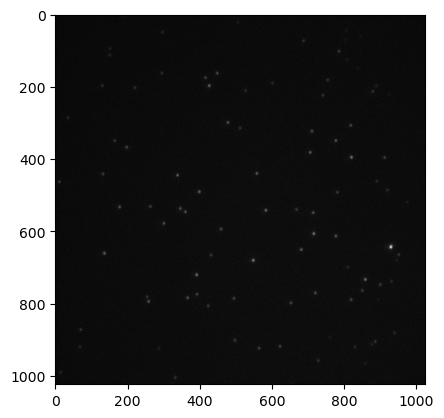

In [13]:
for j in range(len(rawframes)):
    fig, ax = plt.subplots()
    ax.imshow(rawframes[j], cmap='gray')
    for i in range(cents[j].shape[0]):
        # Create a Rectangle patch
        y, x = cents[j][i]
        rect = patches.Rectangle((x-10, y-10), 20, 20, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.title(f"Rawframes[{j}]")
    plt.show()

In [14]:
print(cents)

[]
